<a href="https://colab.research.google.com/github/martinpius/Behind-Keras-Layers-and-Models/blob/main/Alien_Revival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using Google colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")

def time_fmt(t):
  h = int(t / (60 * 60))
  m = int(t % (60 * 60)/60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"

Mounted at /content/drive/
You are using Google colab with tensorflow version: 2.4.0


In [2]:
import tensorflow as tf
import numpy as np
import time
time_fmt(123.4903)

'0: 02: 03.00'

In [30]:
#End to end autoencoder's for cifar10 dataset
#We will train the autoencoder in two different way
#As a ussual MLP and as a CNN

In [31]:
#The ussual MLP 

In [32]:
#Defining the sampling class (layer subclassing): We sample from the normal distribution to instantiate the decoder's inputs

In [33]:
class SampleGenerator(tf.keras.layers.Layer):
  def call(self, inputs):
    mu, sigma = inputs
    dim1 = tf.shape(mu)[0]
    dim2 = tf.shape(mu)[1]
    eps = tf.keras.backend.random_normal(shape = (dim1, dim2))
    return mu + tf.exp(0.5 * sigma) * eps
  

In [34]:
#Defining  the encoder's class (layer-subclassing) which encode the original data/image to some representation

In [35]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, hidden = 64, intermediate = 128, name = 'encoder', **kwargs):
    super(Encoder, self).__init__(name = name, **kwargs)
    self.layer1 = tf.keras.layers.Dense(units = hidden, activation = 'relu', kernel_initializer = 'random_normal')
    self.layer2 = tf.keras.layers.Dense(units = intermediate, activation = 'relu', kernel_initializer = 'random_normal')
    self.mu = tf.keras.layers.Dense(units = intermediate, activation = 'relu', kernel_initializer = 'random_normal')
    self.sigma = tf.keras.layers.Dense(units = intermediate, activation = 'relu', kernel_initializer = 'random_normal')
    self.sample_generator = SampleGenerator()
  
  def call(self, inputs):
    x = self.layer1(inputs)
    x = self.layer2(x)
    mu = self.mu(x)
    sigma = self.sigma(x)
    z = self.sample_generator((mu, sigma))
    return mu, sigma, z


In [36]:
#Defining a decoder's block. This is a layer-subclassing procedure to recreate the original data/image

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,original_dim, hidden = 64,intermediate = 128, name = 'decoder', **kwargs):
    super(Decoder, self).__init__(name = name, **kwargs)
    self.dense1 = tf.keras.layers.Dense(units = hidden, activation = 'relu', kernel_initializer = 'random_normal')
    self.dense2 = tf.keras.layers.Dense(units = intermediate, activation = 'relu', kernel_initializer='random_normal')
    self.out = tf.keras.layers.Dense(units = original_dim, activation ='sigmoid')
  
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    return self.out(x)

In [38]:
#The autoencoder's class: (this is a model-subclassing) procedure. Here we combine encoder's and the decoder's to get an end-to-end model

In [39]:
class MyAutoEncoder(tf.keras.Model):
  def __init__(self, original_dim, hidden = 64, intermediate = 128, name = 'vae', **kwargs):
    super(MyAutoEncoder, self).__init__(name = name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(hidden = hidden, intermediate = intermediate)
    self.decoder = Decoder(original_dim = original_dim, hidden = hidden)
  
  def call(self, inputs):
    mu, sigma, z = self.encoder(inputs)
    re_build = self.decoder(z)
    kl_Div = -0.5 * tf.reduce_mean(sigma - tf.square(mu) - tf.exp(sigma) + 1)
    self.add_loss(kl_Div)
    return re_build


In [40]:
#Instantiate our model 

In [41]:
original_dim = 784 #This is a flat version of  32,32,3 cifar10 image

In [42]:
VAE = MyAutoEncoder(original_dim,64,128)

In [43]:
#Get the data and pre-process (We only need a training set)

In [44]:
(x_train, _),(_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [45]:
x_train.shape

(60000, 28, 28)

In [46]:
x_train = x_train.reshape(60000,784).astype('float32')/255.0

In [47]:
#Change to tensorflow dataset for easy streaming
x_train.shape
train_dfm = tf.data.Dataset.from_tensor_slices(x_train)

In [48]:
train_dfm = train_dfm.shuffle(buffer_size = 1024).batch(64)

In [49]:
epochs = 10

In [50]:
main_loss = tf.keras.losses.MeanAbsoluteError()
metric_fn = tf.keras.metrics.Mean()
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)

In [51]:
#The training loop

In [52]:
tic = time.time()
for epoch in range(epochs):
  print(f"Here we begin training at epoch: {epoch}")

  for step, x_batch_train in enumerate(train_dfm):
    with tf.GradientTape() as tape:
      re_build = VAE(x_batch_train)
      loss = main_loss(x_batch_train, re_build)
      loss+=sum(VAE.losses)#Adding the KL_Divergence loss for autoencoder
    grads = tape.gradient(loss, VAE.trainable_weights)
    optimizer.apply_gradients(zip(grads, VAE.trainable_weights))
    metric_fn(loss)
    if step % 100 == 0:
      print("step %d: mean loss = %.4f" % (step, metric_fn.result()))
toc = time.time()
print(f"Time elapsed: {time_fmt(tic - toc)}")

Here we begin training at epoch: 0
step 0: mean loss = 0.4745
step 100: mean loss = 0.1680
step 200: mean loss = 0.1469
step 300: mean loss = 0.1395
step 400: mean loss = 0.1362
step 500: mean loss = 0.1337
step 600: mean loss = 0.1323
step 700: mean loss = 0.1311
step 800: mean loss = 0.1303
step 900: mean loss = 0.1295
Here we begin training at epoch: 1
step 0: mean loss = 0.1293
step 100: mean loss = 0.1289
step 200: mean loss = 0.1287
step 300: mean loss = 0.1283
step 400: mean loss = 0.1282
step 500: mean loss = 0.1278
step 600: mean loss = 0.1277
step 700: mean loss = 0.1274
step 800: mean loss = 0.1273
step 900: mean loss = 0.1271
Here we begin training at epoch: 2
step 0: mean loss = 0.1270
step 100: mean loss = 0.1269
step 200: mean loss = 0.1269
step 300: mean loss = 0.1267
step 400: mean loss = 0.1267
step 500: mean loss = 0.1266
step 600: mean loss = 0.1265
step 700: mean loss = 0.1264
step 800: mean loss = 0.1264
step 900: mean loss = 0.1262
Here we begin training at epoch

In [53]:
#Autoencoder's for cifar10 data

In [54]:
inputs = tf.keras.Input(shape = (32,32,3), name = 'cifar10_img')
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'valid')(inputs)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'valid')(x)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'valid')(x)
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.GlobalMaxPooling2D()(x)

x = tf.keras.layers.Reshape((8,8,1))(out)
x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.UpSampling2D(size = (2,2))(x)
x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3,3), activation = 'relu')(x)
og_img = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3,3), activation = 'relu', name = 'org_img')(x)
vae = tf.keras.Model(inputs = inputs, outputs = og_img)

In [55]:
vae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cifar10_img (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 10, 10, 64)        73792     
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 10, 64)        256 

In [56]:
my_loss = tf.keras.losses.MeanAbsoluteError()
my_metric = tf.keras.metrics.Mean()
my_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)


In [57]:
epochs = 15

In [58]:
#Load cifar10 dataset
(x_train, _),(_, _) = tf.keras.datasets.cifar10.load_data()

In [59]:
#Preprocess the data and convert to tensorflow datatype in batches of size 64 each
x_train = x_train.astype('float32')/255.0

In [60]:
x_train.shape

(50000, 32, 32, 3)

In [61]:
train_dfm = tf.data.Dataset.from_tensor_slices(x_train)
train_dfm = train_dfm.shuffle(buffer_size = 1024).batch(64)

In [62]:
tic = time.time()
for epoch in range(epochs):
  print(f"The start of epoch: {epoch}")
  for step,x_train_batch in enumerate(train_dfm):
    with tf.GradientTape() as tape:
      org_img = vae(x_train_batch)
      loss = my_loss(x_train_batch, org_img)
      loss+= loss
    grads = tape.gradient(loss, vae.trainable_weights)
    my_optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    my_metric(loss)
    if step % 100 == 0:
      print("step %d: mean loss = %.4f" % (step, my_metric.result()))
toc = time.time()
print(f"time elapsed: {tic - toc}")

The start of epoch: 0
step 0: mean loss = 0.9166
step 100: mean loss = 0.5413
step 200: mean loss = 0.4840
step 300: mean loss = 0.4627
step 400: mean loss = 0.4515
step 500: mean loss = 0.4424
step 600: mean loss = 0.4344
step 700: mean loss = 0.4257
The start of epoch: 1
step 0: mean loss = 0.4190
step 100: mean loss = 0.4120
step 200: mean loss = 0.4059
step 300: mean loss = 0.4003
step 400: mean loss = 0.3949
step 500: mean loss = 0.3904
step 600: mean loss = 0.3860
step 700: mean loss = 0.3821
The start of epoch: 2
step 0: mean loss = 0.3789
step 100: mean loss = 0.3755
step 200: mean loss = 0.3723
step 300: mean loss = 0.3694
step 400: mean loss = 0.3666
step 500: mean loss = 0.3641
step 600: mean loss = 0.3616
step 700: mean loss = 0.3593
The start of epoch: 3
step 0: mean loss = 0.3574
step 100: mean loss = 0.3552
step 200: mean loss = 0.3531
step 300: mean loss = 0.3513
step 400: mean loss = 0.3494
step 500: mean loss = 0.3477
step 600: mean loss = 0.3459
step 700: mean loss =

In [64]:
print(f"time elapsed: {time_fmt(toc - tic)}")

time elapsed: 0: 07: 32.00


In [1]:
#Transfers weights between layers/models in memory

In [3]:
def create_layer():
  dense1 = tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu')
  dense1.build((None, 10))
  return dense1

In [4]:
layer1 = create_layer()
layer2 = create_layer()
#Copy the weights of layer2 into layer1 in memory

In [5]:
layer1.set_weights(layer2.get_weights())

In [6]:
layer1.weights

[<tf.Variable 'kernel:0' shape=(10, 128) dtype=float32, numpy=
 array([[ 0.01219196,  0.01521388,  0.0172997 , ...,  0.00185943,
          0.07479358,  0.09444313],
        [-0.04293034, -0.05951702,  0.10514595, ...,  0.02156232,
         -0.04493762,  0.02061929],
        [ 0.04145955,  0.00827649, -0.03990454, ...,  0.04628895,
         -0.0167529 , -0.03513458],
        ...,
        [-0.00223408,  0.02422469, -0.07955934, ..., -0.03633394,
          0.01366639,  0.04751098],
        [-0.05802162,  0.00649976,  0.0043287 , ...,  0.04398169,
         -0.05317219, -0.00212604],
        [-0.02682946,  0.0966531 ,  0.01498333, ...,  0.08006915,
         -0.00735555,  0.01209113]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [15]:
class MLP(tf.keras.layers.Layer):
  def __init__(self, units = 64, name = 'mlp', **kwargs):
    super(MLP, self).__init__(name = name, **kwargs)
    self.units = units
    self.dense1 = tf.keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal')
    self.out = tf.keras.layers.Dense(units = 10, activation = 'softmax')
  
  def call(self, inputs):
    x = self.dense1(inputs)
    return self.out(x)

mlp = MLP(64)
inputs = tf.keras.Input(shape = (10,))
out = mlp(inputs)
model1 = tf.keras.Model(inputs = inputs, outputs = out, name = 'mlp1')

In [16]:
x = tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu')(inputs)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax')(x)
model2 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mlp2')


In [17]:
model1.summary()
model2.summary()

Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
mlp (MLP)                    (None, 10)                1354      
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________
Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 1,354
Trainable params: 1,354
No

In [25]:
class MLP(tf.keras.Model):
  def __init__(self, name = 'mlp', **kwargs):
    super(MLP, self).__init__(name = name, **kwargs)
    self.dense1 = tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu')
    self.dense2 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
  
  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

mlp3 = MLP('mlp')
x = tf.keras.Input(shape = (10,))
out = mlp3(x)


In [26]:
model3 = tf.keras.Model(inputs = x, outputs = out, name = 'mlp3')

In [27]:
model2.summary()

Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [28]:
model2.summary()

Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Model2 and model3 are similar. We may copy the weights of model2 into model 3

In [30]:
model3.set_weights(model2.get_weights())

In [35]:
model3.weights[0][0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([-0.01534462, -0.05064329,  0.02400648, -0.00213329, -0.00823203,
        0.05355125, -0.02436385,  0.01666885, -0.04729612,  0.04052295,
        0.06036309,  0.04915816, -0.06656834, -0.0058924 , -0.0437604 ,
       -0.00790327,  0.11943638, -0.01702216, -0.01630173, -0.04385459,
        0.00697704,  0.01312253,  0.04664024, -0.10954863, -0.05228733,
       -0.03052824, -0.04021033,  0.06932499, -0.00365266, -0.03061824,
        0.03948629,  0.00508403, -0.01892553,  0.06346243, -0.01796403,
       -0.01961886, -0.05609553,  0.01803293,  0.0006699 , -0.01407005,
        0.04398337,  0.01187514,  0.07431163, -0.01178166,  0.04493083,
       -0.04839073, -0.08507457, -0.00264564,  0.01973548, -0.02368109,
        0.06850316, -0.04140654,  0.056061  , -0.02159815, -0.07319919,
       -0.00670119,  0.0623123 ,  0.04325527,  0.0854376 , -0.03789325,
       -0.08378753, -0.06424625, -0.02531073,  0.01734059], dtype=float32)>

In [36]:
model2.weights[0][0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([-0.01534462, -0.05064329,  0.02400648, -0.00213329, -0.00823203,
        0.05355125, -0.02436385,  0.01666885, -0.04729612,  0.04052295,
        0.06036309,  0.04915816, -0.06656834, -0.0058924 , -0.0437604 ,
       -0.00790327,  0.11943638, -0.01702216, -0.01630173, -0.04385459,
        0.00697704,  0.01312253,  0.04664024, -0.10954863, -0.05228733,
       -0.03052824, -0.04021033,  0.06932499, -0.00365266, -0.03061824,
        0.03948629,  0.00508403, -0.01892553,  0.06346243, -0.01796403,
       -0.01961886, -0.05609553,  0.01803293,  0.0006699 , -0.01407005,
        0.04398337,  0.01187514,  0.07431163, -0.01178166,  0.04493083,
       -0.04839073, -0.08507457, -0.00264564,  0.01973548, -0.02368109,
        0.06850316, -0.04140654,  0.056061  , -0.02159815, -0.07319919,
       -0.00670119,  0.0623123 ,  0.04325527,  0.0854376 , -0.03789325,
       -0.08378753, -0.06424625, -0.02531073,  0.01734059], dtype=float32)>

In [1]:
#Weight transfer from one model to the other

In [2]:
import tensorflow as tf

In [3]:
class NewMLP(tf.keras.Model):
  def __init__(self, name = 'new_mlp', **kwargs):
    super(NewMLP, self).__init__(name = name, **kwargs)
    self.dense1 = tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu')
    self.dense2 = tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu')
    self.out = tf.keras.layers.Dense(units = 10, activation = 'softmax')
  
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    return self.out(x)

mlp = NewMLP('new_mlp')
inputs = tf.keras.Input(shape = (10,))
outputs = mlp(inputs)
model_new = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'new_mlp')


In [4]:
#Now doing the transfers of the weights to a new model
trans_new = tf.keras.Model(inputs = model_new.input, outputs = model_new.layers[-1].input, name = 'mlp_transfer')

In [5]:
model_new.summary()
trans_new.summary()

Model: "new_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
new_mlp (NewMLP)             (None, 10)                10314     
Total params: 10,314
Trainable params: 10,314
Non-trainable params: 0
_________________________________________________________________
Model: "mlp_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [6]:
#We assign weights to our new model as follows:
for W in trans_new.weights:
  W.assign(tf.random_normal(W.shape))
  trans_new.save_weights('my_weights')
  trans_new.summary()

In [10]:
from tensorflow.keras.layers.experimental import preprocessing

In [11]:
dfm = np.array([[1.2,2.3,2.1],[2.3,4.2,1.5],[4.2,4.5,1.4]])

In [12]:
normalize = preprocessing.Normalization()
normalize.adapt(dfm)
dfm_norm = normalize(dfm)

In [13]:
dfm

array([[1.2, 2.3, 2.1],
       [2.3, 4.2, 1.5],
       [4.2, 4.5, 1.4]])

In [14]:
dfm_norm

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-1.1028839 , -1.4029912 ,  1.4018258 ],
       [-0.21519688,  0.5475084 , -0.5391637 ],
       [ 1.3180808 ,  0.8554823 , -0.86266214]], dtype=float32)>

In [18]:
print(f"normalized mean: {dfm_norm.numpy().mean():.2f}\nnormalized std: {dfm_norm.numpy().std():.2f}")

normalized mean: -0.00
normalized std: 1.00


In [19]:
#Text vectorization

In [24]:
layer = preprocessing.TextVectorization()
data = ['Mama anapika', 'ugali na samaki ','halafu wewe', 'usiniletee' ,'mambo ya kiboya']

In [25]:
layer.adapt(data = data)

In [26]:
token_data = layer(data)

In [27]:
token_data

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[ 9, 12,  0],
       [ 5,  7,  6],
       [11,  3,  0],
       [ 4,  0,  0],
       [ 8,  2, 10]])>

In [1]:
#Data augumentantion. Lets perfom some data augumentantion procedures on images

In [4]:
from tensorflow.keras.layers.experimental import preprocessing

In [39]:
inputs_dim = (32,32,3) # cifar10 images for example

In [40]:
num_classes = 10

In [41]:
inputs = tf.keras.Input(shape = inputs_dim, name = 'cifar10_img')

In [42]:
dfm_augumentantion = tf.keras.models.Sequential([
                                                 preprocessing.RandomZoom(height_factor=0.1),
                                                 preprocessing.RandomFlip(mode = 'horizontal'),
                                                 preprocessing.RandomRotation(factor = 0.1),
                                                 preprocessing.RandomContrast(factor = 0.25)
])

In [43]:
aug_dfm = dfm_augumentantion(inputs) #Perform the data augumentantion by modify each image according to the specifications


In [44]:
#We can rescale the data into (0, 1) for easy training

In [45]:
aug_dfm = preprocessing.Rescaling(1.0/255)(aug_dfm)

In [46]:
#Build a Transfer learning model

In [47]:
outputs = tf.keras.applications.ResNet50(weights=None,input_shape=inputs_dim, classes= num_classes)(aug_dfm)

In [49]:
model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [50]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cifar10_img (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 10)                23608202  
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [51]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metric_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

In [52]:
epochs = 10

In [53]:
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [54]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [55]:
(y_train, y_test) = tf.keras.utils.to_categorical(y_train, num_classes= 10), tf.keras.utils.to_categorical(y_test, num_classes=10)

In [56]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [57]:
train_data = train_data.shuffle(buffer_size = 1024).batch(64)

In [58]:
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [61]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [63]:
model.fit(x_train, y_train, epochs = epochs, validation_split=0.1, verbose = 2)

Epoch 1/10
1407/1407 - 64s - loss: 2.3292 - accuracy: 0.2887 - val_loss: 3.5653 - val_accuracy: 0.2904
Epoch 2/10
1407/1407 - 51s - loss: 2.0652 - accuracy: 0.3503 - val_loss: 2.1050 - val_accuracy: 0.2508
Epoch 3/10
1407/1407 - 51s - loss: 1.8870 - accuracy: 0.3854 - val_loss: 2.8982 - val_accuracy: 0.4098
Epoch 4/10
1407/1407 - 51s - loss: 1.8405 - accuracy: 0.4125 - val_loss: 195.1792 - val_accuracy: 0.1030
Epoch 5/10
1407/1407 - 51s - loss: 2.1305 - accuracy: 0.3009 - val_loss: 1.7792 - val_accuracy: 0.3596
Epoch 6/10
1407/1407 - 51s - loss: 1.9507 - accuracy: 0.3448 - val_loss: 2.5808 - val_accuracy: 0.4162
Epoch 7/10
1407/1407 - 51s - loss: 1.8308 - accuracy: 0.3886 - val_loss: 53.9608 - val_accuracy: 0.1434
Epoch 8/10
1407/1407 - 51s - loss: 1.8710 - accuracy: 0.3697 - val_loss: 2.7431 - val_accuracy: 0.4096
Epoch 9/10
1407/1407 - 51s - loss: 1.7813 - accuracy: 0.3933 - val_loss: 2.3260 - val_accuracy: 0.4120
Epoch 10/10
1407/1407 - 51s - loss: 1.6300 - accuracy: 0.4356 - val_lo

In [5]:
#Text preprocessing for sequence model

In [14]:
texts = tf.constant([
                     'Love is always a wonderful thing ever existed',
                     'Bob always sings love songs',
                     'But it is difficult to find the true love',
                     'Too much love can damage your heart once its gone',
                     'It is so romantic to be loved by someone you real love',
                     'Unfortunately I have an iron heart to trust a woman'
])

In [15]:
text_enc = preprocessing.TextVectorization(output_mode='int')
text_enc.adapt(texts)

In [16]:
my_voc_list = text_enc.get_vocabulary()

In [17]:
print("Vocubulary:", my_voc_list)

Vocubulary: ['', '[UNK]', 'love', 'to', 'is', 'it', 'heart', 'always', 'a', 'your', 'you', 'wonderful', 'woman', 'unfortunately', 'trust', 'true', 'too', 'thing', 'the', 'songs', 'someone', 'so', 'sings', 'romantic', 'real', 'once', 'much', 'loved', 'its', 'iron', 'i', 'have', 'gone', 'find', 'existed', 'ever', 'difficult', 'damage', 'can', 'by', 'but', 'bob', 'be', 'an']


In [19]:
#Building a keras model:
inputs = tf.keras.Input(shape = (1,),dtype = 'string')
x = text_enc(inputs)
x = tf.keras.layers.Embedding(input_dim= len(my_voc_list), output_dim = 32)(x)
outputs = tf.keras.layers.LSTM(units = 1)(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 32)          1408      
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 136       
Total params: 1,544
Trainable params: 1,544
Non-trainable params: 0
_________________________________________________________________


In [1]:
#Model subclassing to control what happens in the training step (the fit() method)
#We may want to customize the fit method to suit our need

In [42]:
class MyCustom(tf.keras.Model):
  def train_step(self, data):
    x, y = data #unpack the data (this may be a numpy arrays tupple or a tf.dataset format)
    with tf.GradientTape() as tape:
      y_pred = self(x, training = True)
      loss = self.compiled_loss(y, y_pred, regularization_losses = self.losses)
    trainable_vars = self.trainable_variables
    grads = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(grads, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {k.name:k.result() for k in self.metrics}

In [43]:
#The simple model by applying the above customized training step

In [44]:
inputs = tf.keras.Input(shape = (32,))
x = tf.keras.layers.Dense(units =128, activation = 'relu', kernel_initializer = 'random_normal')(inputs)
x = tf.keras.layers.Dense(units = 64, activation ='relu', kernel_initializer = 'random_normal')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax')(x)
model = MyCustom(inputs, outputs)


In [45]:
model.summary()

Model: "my_custom_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                650       
Total params: 13,130
Trainable params: 13,130
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Test the model with some fake data

In [47]:
x, y = np.random.random(size = (100, 32)), np.random.random(size = (100, 10))

In [48]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [49]:
model.fit(x,y, epochs = 3)

Epoch 1/3
4/4 [==============================] - 2s 4ms/step - loss: 11.6840 - accuracy: 0.0707
Epoch 2/3
4/4 [==============================] - 0s 3ms/step - loss: 11.7261 - accuracy: 0.0368
Epoch 3/3
4/4 [==============================] - 0s 3ms/step - loss: 11.6439 - accuracy: 0.0584


In [3]:
#Customized fit() method with labels/class  priority using sample_weights (for regression) or class weights (for classificaton)

In [21]:
class MyCustomFit(tf.keras.Model):
  def train_step(self, data):
    if len(data)==3:
      x, y, sample_weight = data
    else:
      x,y = data #unpacking the data
    with tf.GradientTape() as tape:
      y_pred = self(x,training = True)
      loss = self.compiled_loss(y, y_pred, sample_weight = sample_weight, regularization_losses = self.losses)
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred,sample_weight = sample_weight)
    return {k.name : k.result() for k in self.metrics}


In [22]:
#Build a simple mlp and fit as ussual but the above customization will be used

In [23]:
inputs = tf.keras.Input(shape = (64, ))
x = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'random_normal')(inputs)
x = tf.keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal')(x)
outputs = tf.keras.layers.Dense(units = 1)(x)
model = MyCustomFit(inputs, outputs, name = 'mlp')

In [24]:
model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


In [25]:
x = np.random.random(size = (100, 64))
y = np.random.random(size = (100, 1))
s_wt = np.random.random(size = (100,1))
model.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [28]:
model.fit(x,y, sample_weight=s_wt, epochs = 1)

4/4 [==============================] - 0s 2ms/step - loss: 3.1678e-08 - accuracy: 0.0000e+00


In [29]:
#A custumized evaluation step can also be constructed to suit a user's requirements

In [30]:
#We use model subclassing just like in the training-step we define our own test_step

In [50]:
class MyEval(tf.keras.Model):
  def test_step(self, data):
    if len(data) == 3:
      x, y, sample_weight = data
    else:
      x, y = data
    with tf.GradientTape() as tape:
      y_pred = self(x, training = True)#Foward pass to get the predictions
      loss = self.compiled_loss(y_pred, y, sample_weight = sample_weight, regularization_losses = self.losses)
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred, sample_weight = sample_weight)
    return {k.name : k.result() for k in self.metrics}

In [51]:
#Using the above we build the testing model as follow 

In [52]:
inputs = tf.keras.Input(shape = (10,))
outputs = tf.keras.layers.Dense(units = 1)(inputs)
model = MyEval(inputs = inputs, outputs = outputs, name = 'eval_mlp')

In [53]:
model.summary()

Model: "eval_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [54]:
x = np.random.random(size = (100, 10))
y = np.random.random(size = (100,1))
s_wt = np.random.random(size = (100,1))

In [55]:
model.compile(loss = 'mse', metrics = ['mae'])

In [56]:
model.evaluate(x, y, sample_weight=s_wt)

4/4 [==============================] - 0s 2ms/step - loss: 0.1141 - mae: 0.4126


[0.11587373912334442, 0.41385841369628906]

In [57]:
#Generative Adversarial Network from end to end with customized training step:
#GAN has two parts like any other encoder's decoder's models
#First we have a generator ( this generate fake data (images for example))
#Second we have a discriminator that try to classify if the data is fake or real
#We have two optimizers for each generator and discriminator but one loss function because only the discriminator get trained

In [114]:
#GAN-the discriminator (takes input as an image (lets say a 32, 32,3), image)
class Discriminator(tf.keras.layers.Layer):
  def __init__(self, name = 'discriminator', **kwargs):
    super(Discriminator, self).__init__(name = name, **kwargs)
    self.conv1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),
                                        strides = (2,2), padding = 'same',
                                        activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),
                                        activation = tf.keras.layers.LeakyReLU(alpha = 0.2),
                                        strides = (2,2), padding = 'same')
    self.bn = tf.keras.layers.BatchNormalization()
    self.maxpool = tf.keras.layers.MaxPooling2D(pool_size = (2,2))
    self.conv3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2),
                                        activation = tf.keras.layers.LeakyReLU(alpha = 0.2), padding = 'same')
    self.conv4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),
                                        strides = (2,2), padding = 'same',
                                        activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.glb = tf.keras.layers.GlobalMaxPool2D()
    self.classify = tf.keras.layers.Dense(units = 1)
  
  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.bn(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.glb(x)
    return self.classify(x)

In [115]:
discriminator = Discriminator(name = 'discriminator')
inputs = tf.keras.Input(shape = (32,32,3))
outputs = discriminator(inputs)

In [116]:
model1 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'discriminator')

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
discriminator (Discriminator (None, 1)                 225345    
Total params: 225,345
Trainable params: 225,217
Non-trainable params: 128
_________________________________________________________________


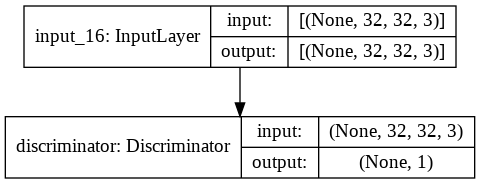

In [117]:
model1.summary()
tf.keras.utils.plot_model(model = model1, to_file = 'discriminator.png', show_shapes = True)

In [118]:
model_fn.summary()

Model: "cnn_fn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 1, 64)          73792

In [119]:
class Generator(tf.keras.layers.Layer):
  def __init__(self, name = 'generator', **kwargs):
    super(Generator, self).__init__(name = name, **kwargs)
    self.reshape = tf.keras.layers.Reshape((8,8,1))
    self.convtrans1 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), 
                                                      activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.convtrans2 = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3,3),
                                               activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.upsampling = tf.keras.layers.UpSampling2D(size = (2,2))
    self.convtrans3 =tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3),
                                                     activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.convtrans4 = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3,3),
                                                       activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.convtrans5 = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3,3),
                                                      activation = tf.keras.layers.LeakyReLU(alpha = 0.2))
    self.out3 = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3,3), activation = 'sigmoid')
  
  def call(self, inputs):
    x = self.reshape(inputs)
    x = self.convtrans1(x)
    x = self.convtrans2(x)
    x = self.upsampling(x)
    x = self.convtrans3(x)
    x = self.convtrans4(x)
    x = self.convtrans5(x)
    return self.out3(x)
    

In [120]:
mygen = Generator(name = 'generator')
inputs = tf.keras.Input(shape = (64,))
outputs = mygen(inputs)
gen_mod = tf.keras.Model(inputs = inputs, outputs = outputs)

In [121]:
gen_mod.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
generator (Generator)        (None, 32, 32, 3)         373187    
Total params: 373,187
Trainable params: 373,187
Non-trainable params: 0
_________________________________________________________________


In [17]:
discriminator = tf.keras.models.Sequential([
                            tf.keras.Input(shape = (28,28,1)),
                            tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                            tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
                            tf.keras.layers.GlobalMaxPooling2D(),
                            tf.keras.layers.Dense(units = 1)
], name = 'discriminator')

In [18]:
latent_dim = 128
generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(7 * 7 * 128),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [19]:
#The GAN using model subclassing (We merge the above classes in one)

In [20]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator
  
  def compile(self, d_optm, g_optm, d_loss):
    super(GAN, self).compile()
    self.d_optm = d_optm
    self.g_optm = g_optm
    self.d_loss = d_loss
  
  def train_step(self, real_imgs):
    if isinstance(real_imgs, tuple):
      real_imgs = real_imgs[0]
    batch_size = tf.shape(real_imgs)[0]
    #Sample some points in the latent space
    rand_latent_vecs = tf.random.normal(shape = (batch_size, self.latent_dim))
    #Fake images generation
    fake_img = self.generator(rand_latent_vecs)
    #Concat with real data(images)
    imgs_combined = tf.concat([fake_img, real_imgs], axis = 0)
    labels = tf.concat([
                        tf.ones(shape = (batch_size, 1)), tf.zeros(shape = (batch_size,1))
    ], axis = 0)
    labels+=0.05 * tf.random.uniform(tf.shape(labels))
    with tf.GradientTape() as tape:
      predictions = self.discriminator(imgs_combined)
      loss = self.d_loss(labels, predictions)
    grads = tape.gradient(loss, self.discriminator.trainable_weights)
    self.d_optm.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
    rand_latent_vecs = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(rand_latent_vecs))
      g_loss = self.d_loss(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optm.apply_gradients(zip(grads, self.generator.trainable_weights))
    return {"d_loss": loss, "g_loss": g_loss}
      

In [22]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
all_images = np.concatenate([x_train, x_test])
all_images = all_images.astype("float32") / 255.0
all_images = np.reshape(all_images, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_images)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(latent_dim= latent_dim, generator = generator, discriminator = discriminator)
gan.compile(
    d_optm=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optm=tf.keras.optimizers.Adam(learning_rate=0.0003),
    d_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset.take(100), epochs=1)

100/100 [==============================] - 342s 3s/step - d_loss: 0.4850 - g_loss: 0.8030
